In [1]:
!nvidia-smi

Fri Dec  4 06:50:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/My Drive/face

/content/drive/My Drive/face


In [4]:
! ls data

1.mp4


In [5]:
import os
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
from PIL import Image
import torch
import time

In [7]:
video_path = '/content/drive/My Drive/face/data/'

reader = cv2.VideoCapture(video_path + '1.mp4')

image_list = []
for i in tqdm(range(int(reader.get(cv2.CAP_PROP_FRAME_COUNT)))):
    _, image = reader.read()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_list.append(image)
reader.release()

images_np = np.stack(image_list)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [8]:
images_np.shape

(300, 1080, 1920, 3)

In [9]:
def plot_faces(images, figsize=(10.8/2, 19.2/2)):
    shape = images[0].shape
    images = images[np.linspace(0, len(images)-1, 16).astype(int)]
    im_plot = []
    for i in range(0, 16, 4):
        im_plot.append(np.concatenate(images[i:i+4], axis=0))
    im_plot = np.concatenate(im_plot, axis=1)
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(im_plot)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    ax.grid(False)
    fig.tight_layout()

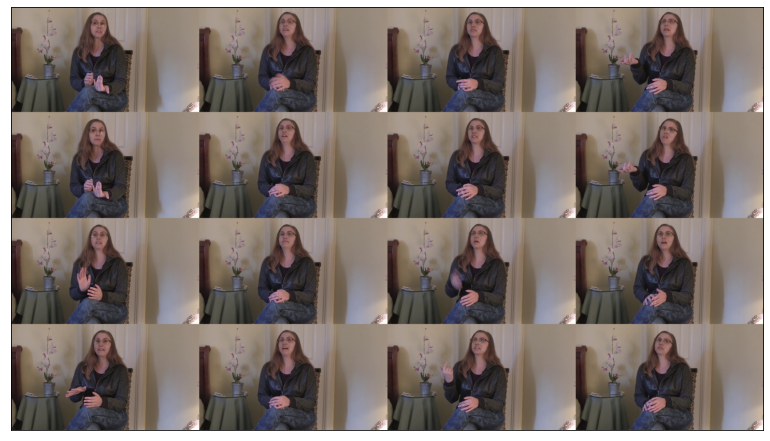

In [10]:
plot_faces(images_np, figsize=(10.8, 19.2))

In [11]:
def timer(detector, detect_fn, images, *args):
    start = time.time()
    faces = detect_fn(detector, images, *args)
    elapsed = time.time() - start
    print(f', {elapsed:.3f} seconds')
    return faces, elapsed

In [16]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [14]:
!pip install facenet_pytorch

     |████████████████████████████████| 1.9MB 8.9MB/s 


In [17]:
from facenet_pytorch import MTCNN
detector = MTCNN(device=device, post_process=False)

In [18]:
def detect_facenet_pytorch(detector, images, batch_size):
    faces = []
    for lb in np.arange(0, len(images), batch_size):
        imgs_pil = [Image.fromarray(image) for image in images[lb:lb+batch_size]]
        faces.extend(detector(imgs_pil))
    return faces

times_facenet_pytorch = []    # batched
times_facenet_pytorch_nb = [] # non-batched

Detecting faces in 1080x1920 frames, 14.546 seconds


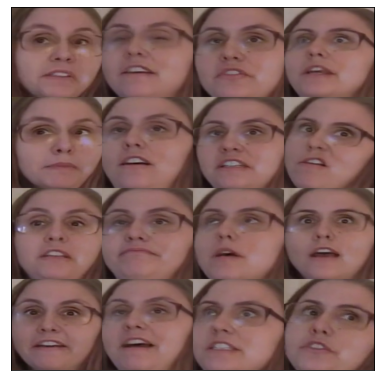

In [19]:
print('Detecting faces in 1080x1920 frames', end='')
faces, elapsed = timer(detector, detect_facenet_pytorch, image_list, 20)
times_facenet_pytorch.append(elapsed)

plot_faces(torch.stack(faces).permute(0, 2, 3, 1).int().numpy())

In [71]:
#FaceNet을 사용한 그림 인식
#https://jkisaaclee.kro.kr/keras/facenet/deep%20learning/computer%20vision/2019/10/01/how_to_develop_a_face_recognition_system_using_facenet_in_keras_ko/

In [20]:
from keras.models import load_model

In [24]:
model = load_model('/content/drive/My Drive/face/data/facenet_keras.h5')

In [26]:
print(model.inputs)
print(model.outputs)

[<tf.Tensor 'input_1:0' shape=(None, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/batchnorm/add_1:0' shape=(None, 128) dtype=float32>]


In [28]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 8.2MB/s 


In [29]:
import mtcnn

In [31]:
from os import listdir
from PIL import Image
from numpy import asarray
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN

1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)
5 (160, 160, 3)
6 (160, 160, 3)
7 (160, 160, 3)
8 (160, 160, 3)
9 (160, 160, 3)
10 (160, 160, 3)
11 (160, 160, 3)
12 (160, 160, 3)
13 (160, 160, 3)
14 (160, 160, 3)


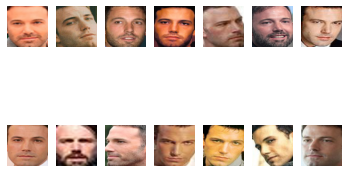

In [34]:
def extract_face(filename, required_size=(160, 160)):
	# 파일에서 이미지 불러오기
	image = Image.open(filename)
	# RGB로 변환, 필요시
	image = image.convert('RGB')
	# 배열로 변환
	pixels = asarray(image)
	# 감지기 생성, 기본 가중치 이용
	detector = MTCNN()
	# 이미지에서 얼굴 감지
	results = detector.detect_faces(pixels)
	# 첫 번째 얼굴에서 경계 상자 추출
	x1, y1, width, height = results[0]['box']
	# 버그 수정
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# 얼굴 추출
	face = pixels[y1:y2, x1:x2]
	# 모델 사이즈로 픽셀 재조정
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# 폴더를 플롯으로 구체화하기
folder = '/content/drive/My Drive/face/data/5-celebrity-faces-dataset/train/ben_afflek/'
i = 1
# 파일 열거
for filename in listdir(folder):
	# 경로
	path = folder + filename
	# 얼굴 추출
	face = extract_face(path)
	print(i, face.shape)
	# 플롯
	pyplot.subplot(2, 7, i)
	pyplot.axis('off')
	pyplot.imshow(face)
	i += 1
pyplot.show()

In [46]:
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model

In [47]:
def load_faces(directory):
	faces = list()
	# 파일 열거
	for filename in listdir(directory):
		# 경로
		path = directory + filename
		# 얼굴 추출
		face = extract_face(path)
		# 저장
		faces.append(face)
	return faces

In [48]:
# 이미지를 포함하는 각 클래스에 대해 하나의 하위 디렉토리가 포함된 데이터셋을 불러오기
def load_dataset(directory):
	X, y = list(), list()
	# 클래스별로 폴더 열거
	for subdir in listdir(directory):
		# 경로
		path = directory + subdir + '/'
		# 디렉토리에 있을 수 있는 파일을 건너뛰기(디렉토리가 아닌 파일)
		if not listdir(path):
			continue
		# 하위 디렉토리의 모든 얼굴 불러오기
		faces = load_faces(path)
		# 레이블 생성
		labels = [subdir for _ in range(len(faces))]
		# 진행 상황 요약
		print('>%d개의 예제를 불러왔습니다. 클래스명: %s' % (len(faces), subdir))
		# 저장
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)

In [81]:
# 훈련 데이터셋 불러오기
trainX, trainy = load_dataset('/content/drive/My Drive/face/data/5-celebrity-faces-dataset/train/')
print(trainX.shape, trainy.shape)
# 테스트 데이터셋 불러오기
testX, testy = load_dataset('/content/drive/My Drive/face/data/5-celebrity-faces-dataset/val/')
print(testX.shape, testy.shape)
# 배열을 단일 압축 포맷 파일로 저장
savez_compressed('/content/drive/My Drive/face/data/5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

>22개의 예제를 불러왔습니다. 클래스명: mindy_kaling
>19개의 예제를 불러왔습니다. 클래스명: madonna
>21개의 예제를 불러왔습니다. 클래스명: jerry_seinfeld
>17개의 예제를 불러왔습니다. 클래스명: elton_john
>14개의 예제를 불러왔습니다. 클래스명: ben_afflek
>1개의 예제를 불러왔습니다. 클래스명: min_chul
(94, 160, 160, 3) (94,)
>5개의 예제를 불러왔습니다. 클래스명: mindy_kaling
>5개의 예제를 불러왔습니다. 클래스명: madonna
>5개의 예제를 불러왔습니다. 클래스명: jerry_seinfeld
>5개의 예제를 불러왔습니다. 클래스명: elton_john
>5개의 예제를 불러왔습니다. 클래스명: ben_afflek
>1개의 예제를 불러왔습니다. 클래스명: min_chul
(26, 160, 160, 3) (26,)


In [82]:
data = load('/content/drive/My Drive/face/data/5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('데이터셋: 훈련=%d, 테스트=%d' % (trainX.shape[0], testX.shape[0]))

데이터셋: 훈련=94, 테스트=26


In [83]:
# facenet 모델 불러오기
model = load_model('/content/drive/My Drive/face/data/facenet_keras.h5')
print('모델 불러오기')

모델 불러오기


In [84]:
# facenet을 이용해 데이터셋 내 각 얼굴에 대한 얼굴 임베딩 계산
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model

# 하나의 얼굴의 얼굴 임베딩 얻기
def get_embedding(model, face_pixels):
	# 픽셀 값의 척도
	face_pixels = face_pixels.astype('int32')
	# 채널 간 픽셀값 표준화(전역에 걸쳐)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# 얼굴을 하나의 샘플로 변환
	samples = expand_dims(face_pixels, axis=0)
	# 임베딩을 갖기 위한 예측 생성
	yhat = model.predict(samples)
	return yhat[0]

# 얼굴 데이터셋 불러오기
data = load('/content/drive/My Drive/face/data/5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('불러오기: ', trainX.shape, trainy.shape, testX.shape, testy.shape)
# facenet 모델 불러오기
model = load_model('/content/drive/My Drive/face/data/facenet_keras.h5')
print('모델 불러오기')
# 훈련 셋에서 각 얼굴을 임베딩으로 변환하기
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# 테스트 셋에서 각 얼굴을 임베딩으로 변환하기
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
# 배열을 하나의 압축 포맷 파일로 저장
savez_compressed('/content/drive/My Drive/face/data/5-celebrity-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

불러오기:  (94, 160, 160, 3) (94,) (26, 160, 160, 3) (26,)
모델 불러오기
(94, 128)
(26, 128)


In [85]:
# 5명의 유명인사 얼굴 데이터셋으로 분류기 개발
from numpy import load
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

In [86]:
# 데이터셋 불러오기
data = load('/content/drive/My Drive/face/data/5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('데이터셋: 훈련=%d, 테스트=%d' % (trainX.shape[0], testX.shape[0]))

데이터셋: 훈련=94, 테스트=26


In [87]:
# 입력 벡터 일반화
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# 목표 레이블 암호화
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# 모델 맞추기(적합시키기)
model = SVC(kernel='linear')
model.fit(trainX, trainy)
# 추측
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# 정확도 점수
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# 요약
print('정확도: 훈련=%.3f, 테스트=%.3f' % (score_train*100, score_test*100))

정확도: 훈련=100.000, 테스트=96.154


예상: elton_john (46.650)
추측: min_chul


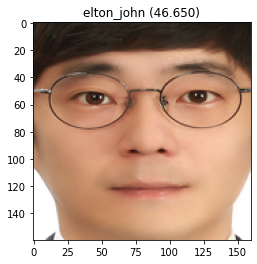

In [95]:
# 5명의 유명인사 얼굴 데이터셋의 분류기 개발
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
# 얼굴 불러오기
data = load('/content/drive/My Drive/face/data/5-celebrity-faces-dataset.npz')
testX_faces = data['arr_2']
# 얼굴 임베딩 불러오기
data = load('/content/drive/My Drive/face/data/5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
# 입력 벡터 일반화
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# 목표 레이블 암호화
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# 모델 적합
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# 테스트 데이터셋에서 임의의 예제에 대한 테스트 모델
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
# 얼굴 예측
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# 이름 얻기
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('예상: %s (%.3f)' % (predict_names[0], class_probability))
print('추측: %s' % random_face_name[0])
# 재미삼아 그리기
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()